In [1]:
# the classics
import pandas as pd
import numpy as np
import os 
import glob as glob
import scipy
from scipy import stats
import warnings

# hydroeval for NSE, KGE
import hydroeval as he

# my helperfunctions as defined in notebook 3
from helperfunctions import *

# mapping stuff
from shapely.geometry.point import Point
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib import colors
import geopandas as gpd

# plotting stuff
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

plt.rcParams.update({'font.size': 14})

Test 2: use a Monte Carlo technique to paramterize the stream network model

In [2]:
df = pd.read_csv('map/network_merged.csv')

In [3]:
## read in chemistry obs data
chemdf = pd.read_csv('data/watersamples_merged.csv',parse_dates=['datetime'],na_values=['nan','NAN','ibid'])

# define other sample groups
pzs = chemdf.loc[chemdf['sample_type']=='PZ',:]
springs = chemdf.loc[chemdf['sample_type']=='SP',:]
ponds = chemdf.loc[chemdf['sample_type']=='P',:]
streams = chemdf.loc[chemdf['sample_type']=='R',:]

In [4]:
# initial parameters
# just gw alkalinity
gw_alk = np.mean(df['Alkalinity_meq_L'])#/1000 # don't divide by 1000 so we can put mM in the table

# some other constants
kh = np.mean(df['KHenry'])# Henrys law, Molar / atm
pCO2_atm = 420 # pco2 in atmosphere
c_atm = kh * pCO2_atm/1e6 # convert pCO2 to atm (ppm -> 1e6) this is 2.45e-5 Saccardi Winnick used c_atm = 2.13e-5
co2_delta_atm = -9 # co2 isotope content in atm
c_iso_atm = c_atm*delta2r(co2_delta_atm) # convert to concentraiton of 13C
delta_x=10 # length of cell in network = 10m


# make a prior dataframe to sample from
df_priors = pd.DataFrame(columns=['min','max'])
# priors were adjusted manually to get a sufficiently wide prior to calibrate the model 

# MC k600
df_priors.loc['k600_a',:] = [500,1500]
df_priors.loc['k600_b',:] = [0.6,1.2]

# MC source DIC and chemistry
df_priors.loc['gw_DIC',:] = [gw_alk,0.8]
df_priors.loc['wet_DIC',:] = [gw_alk,0.8]
df_priors.loc['gw_CO2_delta',:] = [-32,-18]
df_priors.loc['wet_CO2_delta',:] = [-32,-18]
df_priors.loc['gw_rn',:] = [200,800]

# save
df_priors.to_csv('modeloutputs/test2_priors.csv')

# make a table of the priors 
table3 = pd.DataFrame(index=['k$_{600}$ power-law a','k$_{600}$ power-law b','Groundwater DIC','Wetland DIC',
                             'Groundwater $\delta^{13}$C-CO$_{2}$','Wetland $\delta^{13}$C-CO$_{2}$',
                             'Groundwater $^{222}$Rn'])
table3['units'] = ['-','-','mM','mM','‰','‰','(Bq m$^{-3}$)']
table3['range'] = [f'{df_priors.loc[i,"min"]} - {df_priors.loc[i,"max"]}' for i in df_priors.index]
table3.loc[['Groundwater DIC','Wetland DIC'],'range'] = [f'{round(gw_alk,3)} - 0.800',f'{round(gw_alk,3)} - 0.800']

# export
table3.to_csv('tables/Table3.csv')
# take a look
table3

,units,range
k$_{600}$ power-law a,-,500 - 1500
k$_{600}$ power-law b,-,0.6 - 1.2
Groundwater DIC,mM,0.323 - 0.800
Wetland DIC,mM,0.323 - 0.800
Groundwater $\delta^{13}$C-CO$_{2}$,‰,-32 - -18
Wetland $\delta^{13}$C-CO$_{2}$,‰,-32 - -18
Groundwater $^{222}$Rn,(Bq m$^{-3}$),200 - 800


To run 30,000 MC iterations, I use the multiprocessing package to run on all cores of my laptop. To do this, I make a .py file that counts as 1 iteration of randomly sampled priors. 

In [5]:
%%writefile networkmodelmc.py

import pandas as pd
import numpy as np
import hydroeval as he
import scipy
import time
import os

from helperfunctions import *

df_priors = pd.read_csv('modeloutputs/test2_priors.csv',index_col=0)

df = pd.read_csv('map/network_merged.csv',index_col=0)
df =df.rename(columns={'d13C_permil':'dic_delta_meas','dic_calc':'dic_meas','pco2':'pco2_meas','Rn_bq_m3':'rn_meas'})

strahlerlist = [1,2,3,4]

def networkmodelmc(index):
    upstreamnetwork = pd.read_csv('map/network_upstream.csv',index_col=0)

    ### set random seed (multiprocessing workers inherit same seed)
    np.random.seed((os.getpid() * int(time.time())) % 123456789)

    ### some constants:
    gw_alk = np.mean(df['Alkalinity_meq_L'])/1000

    co2_delta_atm = -9 
    pCO2_atm = 420
    delta_x=10   
    mintemp=np.mean(df['temperature_filled'])
    
    # random sampling of parameters
    mcresults = pd.DataFrame()
    # k600
    a = np.random.uniform(df_priors.loc['k600_a','min'],df_priors.loc['k600_a','max'])
    b = np.random.uniform(df_priors.loc['k600_b','min'],df_priors.loc['k600_b','max'])
    # source chemistry
    gw_rn = np.random.uniform(df_priors.loc['gw_rn','min'],df_priors.loc['gw_rn','max'])
    gw_DIC = np.random.uniform(df_priors.loc['gw_DIC','min'],df_priors.loc['gw_DIC','max'])/1000
    wet_DIC = np.random.uniform(df_priors.loc['wet_DIC','min'],df_priors.loc['wet_DIC','max'])/1000
    gw_CO2_delta = np.random.uniform(df_priors.loc['gw_CO2_delta','min'],df_priors.loc['gw_CO2_delta','max'])
    wet_CO2_delta = np.random.uniform(df_priors.loc['gw_CO2_delta','min'],df_priors.loc['gw_CO2_delta','max'])
    
    # calc dic delta value from the other variables
    gw_DIC_delta = epsilon_co2_dic(gw_DIC,gw_alk,gw_CO2_delta,mintemp)
    wet_DIC_delta= epsilon_co2_dic(wet_DIC,gw_alk,wet_CO2_delta,mintemp)
    # calc pco2 from other variables
    gw_pco2 = phfromalk(gw_DIC,gw_alk,mintemp)[-1]
    wet_pco2 = phfromalk(wet_DIC,gw_alk,mintemp)[-1]

    # save all of these
    mcresults.loc[index,'a'] = a
    mcresults.loc[index,'b'] = b
    mcresults.loc[index,'gw_rn'] = gw_rn
    mcresults.loc[index,'gw_DIC'] = gw_DIC
    mcresults.loc[index,'wet_DIC'] = wet_DIC
    mcresults.loc[index,'gw_d13c'] = gw_DIC_delta
    mcresults.loc[index,'wet_d13c'] = wet_DIC_delta
    mcresults.loc[index,'gw_d13c_co2'] = gw_CO2_delta
    mcresults.loc[index,'wet_d13c_co2'] = wet_CO2_delta
    mcresults.loc[index,'gw_pco2'] = gw_pco2
    mcresults.loc[index,'wet_pco2'] = wet_pco2

    # initialize
    df_iter = df.copy()
    lastcell = pd.DataFrame()
    
    df_iter.loc[:,'k600_mc'] = a*(df['velocity']*-df['slope'])**b

    df_iter['co2_atm'] = henryco2(df_iter['temperature_filled'])  * pCO2_atm/10**6# this is 2.14e-5 Saccardi Winnick used c_atm = 2.13e-5
    df_iter['co2_iso_atm'] = df_iter['co2_atm']*delta2r(co2_delta_atm)

    s_co2 = schmidtco2(df_iter['temperature_filled'])
    s_rn = schmidtrn(df_iter['temperature_filled'])
    df_iter['kco2'] = (df_iter[f'k600_mc']/(600/s_co2)**-0.5)/(24*60*60) # m/day to m/s
    df_iter['krn'] = (df_iter[f'k600_mc']/(600/s_rn)**-0.5)/(24*60*60)
    df_iter.loc[np.isnan(df_iter['kco2']),'kco2'] = np.nanmin(df_iter.loc[df_iter['kco2']>0,'kco2'])
    df_iter.loc[np.isnan(df_iter['krn']),'krn'] = np.nanmin(df_iter.loc[df_iter['krn']>0,'krn'])

    toponums = list(set(df['topo']))

    for t in list(reversed(toponums)):

        tempdf_topo = df_iter.loc[df_iter['topo']==t,:]

        segmentlist = set(tempdf_topo['stream'])

        for seg in segmentlist:
            tempdf = tempdf_topo.loc[tempdf_topo['stream']==seg,:]

            temp_strahler = tempdf['strahler'].values[0]

            tempindex = tempdf_topo.loc[tempdf_topo['stream']==seg,:].index

            if temp_strahler>1:
                tribs = set(df_iter.loc[df_iter['next_stream']==seg,'stream'])
                tribs=upstreamnetwork[upstreamnetwork['down']==seg].index

                if any(np.isnan(lastcell.loc[lastcell['stream'].isin(tribs),'dic'])):
                    print(f'AHHHHH {seg} tribs are bad :0')

                # discharge weighted mixtures
                mix_DIC = np.sum(lastcell.loc[lastcell['stream'].isin(tribs),'dic']*lastcell.loc[lastcell['stream'].isin(tribs),'discharge'])/np.sum(lastcell.loc[lastcell['stream'].isin(tribs),'discharge'])
                mix_DIC_delta = np.sum(lastcell.loc[lastcell['stream'].isin(tribs),'dic_delta']*lastcell.loc[lastcell['stream'].isin(tribs),'discharge'])/np.sum(lastcell.loc[lastcell['stream'].isin(tribs),'discharge'])
                mix_rn = np.sum(lastcell.loc[lastcell['stream'].isin(tribs),'rn']*lastcell.loc[lastcell['stream'].isin(tribs),'discharge'])/np.sum(lastcell.loc[lastcell['stream'].isin(tribs),'discharge'])
                mix_DIC = np.nanmax([mix_DIC,gw_alk+0.00002]) # in case the downstream mixture has higher alk than tribs

                df_iter.loc[tempindex[0],'dic']= mix_DIC
                df_iter.loc[tempindex[0],'co2'] = phfromalk(mix_DIC,gw_alk,df_iter.loc[tempindex[0],'temperature_filled'])[1][0]
                df_iter.loc[tempindex[0],'dic_iso']= mix_DIC*delta2r(mix_DIC_delta)
                df_iter.loc[tempindex[0],'co2_iso']= delta2r(epsilon_dic_co2(mix_DIC,gw_alk,mix_DIC_delta,df_iter.loc[tempindex[0],'temperature_filled']))*df_iter.loc[tempindex[0],'co2']
                df_iter.loc[tempindex[0],'rn']= mix_rn


            else: # if first order, first value is just groundwater
                df_iter.loc[tempindex[0],'dic']= gw_DIC/1
                df_iter.loc[tempindex[0],'co2'] = phfromalk(gw_DIC,gw_alk,df_iter.loc[tempindex[0],'temperature_filled'])[1][0]
                df_iter.loc[tempindex[0],'dic_iso']= gw_DIC*delta2r(gw_DIC_delta)
                df_iter.loc[tempindex[0],'co2_iso']= delta2r(epsilon_dic_co2(gw_DIC,gw_alk,gw_DIC_delta,df_iter.loc[tempindex[0],'temperature_filled']))*df_iter.loc[tempindex[0],'co2']
                df_iter.loc[tempindex[0],'rn']= gw_rn

            for i in tempindex[1:]:
                if ~np.isnan(df_iter.loc[i,'wetland']): # if wetland is present, add some pz DIC depending on frac wet
                    c_gw = wet_DIC
                    c_delta_gw = wet_DIC_delta
                    c_iso_gw = c_gw*delta2r(c_delta_gw)
                else:
                    c_gw = gw_DIC
                    c_delta_gw = gw_DIC_delta
                    c_iso_gw = c_gw*delta2r(c_delta_gw)

                df_iter.loc[i,'deltaq'] = df_iter.loc[i,'discharge']-df_iter.loc[i-1,'discharge']

                # Rn steady state solution: in - out
                rn_ss_in = (df_iter.loc[i-1,'rn']*df_iter.loc[i-1,'discharge']+gw_rn*df_iter.loc[i,'deltaq'])/(df_iter.loc[i,'discharge'])
                rn_ss_out = (df_iter.loc[i,'krn']/df_iter.loc[i,'depth'])*(df_iter.loc[i-1,'rn']-0)*delta_x*df_iter.loc[i-1,'xarea']/(df_iter.loc[i,'discharge'])

                # we cant degas more than what is available (0 in atm)
                if rn_ss_out>=rn_ss_in:
                    rn_ss_out = rn_ss_in # substracting a small number so its early equivalent but result is not zero. might not be necessary

                df_iter.loc[i,'rn'] = rn_ss_in-rn_ss_out

                # CO2 steady state solution: in - out
                dic_ss_in = (df_iter.loc[i-1,'dic']*df_iter.loc[i-1,'discharge']+c_gw*df_iter.loc[i,'deltaq'])/(df_iter.loc[i,'discharge'])
                co2_ss_out = (df_iter.loc[i,'kco2']/df_iter.loc[i,'depth'])*(df_iter.loc[i-1,'co2']-df_iter.loc[i-1,'co2_atm'])*delta_x*df_iter.loc[i-1,'xarea']/(df_iter.loc[i,'discharge'])

                # we cant degas more than what is available (some co2 in atm)
                if co2_ss_out>=df_iter.loc[i-1,'co2']-df_iter.loc[i-1,'co2_atm']:
                    co2_ss_out = df_iter.loc[i-1,'co2']-df_iter.loc[i-1,'co2_atm'] # substracting a small number so its early equivalent but result is not zero. might not be necessary

                df_iter.loc[i,'dic'] = dic_ss_in-co2_ss_out

                # now copy co2_ss_out into flux of co2 out... right now it is normalized to discharge (m/s / m) *(mol/L) * m*m^2 / (m3/s)  -> mol/L * m^3/s  /(m^3 /s) -> mol/L.
                # need to multiply discharge back to get mol/L * m^3 / s, then multiply by 1000 to convert mol/L to mol/m^3 to get mol/s, then convert to g/day
                df_iter.loc[i,'fco2'] = co2_ss_out*df_iter.loc[i,'discharge']*1000*12*(24*60*60)
                df_iter.loc[i,'fco2_perarea'] = co2_ss_out*df_iter.loc[i,'discharge']*1000*12*(24*60*60)/(delta_x*df_iter.loc[i,'width'])

                # now speciate using DIC and alk
                [ph,co2,bicarb,carb,pco2] = phfromalk(df_iter.loc[i,'dic'],gw_alk,df_iter.loc[i,'temperature_filled'])
                df_iter.loc[i,'co2'] = co2

                ## iso
                # isotope CO2 steady state solution: in - out
                dic_iso_ss_in = (df_iter.loc[i-1,'dic_iso']*df_iter.loc[i-1,'discharge']+c_iso_gw*df_iter.loc[i,'deltaq'])/(df_iter.loc[i,'discharge'])
                co2_iso_ss_out = (df_iter.loc[i,'kco2']/df_iter.loc[i,'depth'])*(df_iter.loc[i-1,'co2_iso']-df_iter.loc[i-1,'co2_iso_atm'])*delta_x*df_iter.loc[i-1,'xarea']/(df_iter.loc[i,'discharge'])

                # we cant degas more than what is available
                if co2_iso_ss_out>=df_iter.loc[i-1,'co2_iso']-df_iter.loc[i-1,'co2_iso_atm']:
                    co2_iso_ss_out = df_iter.loc[i-1,'co2_iso']-df_iter.loc[i-1,'co2_iso_atm'] # substracting a small number so its early equivalent but result is not zero. might not be necessary


                df_iter.loc[i,'dic_iso'] = dic_iso_ss_in-co2_iso_ss_out

                df_iter.loc[i,'dic_delta'] = r2delta(df_iter.loc[i,'dic_iso']/df_iter.loc[i,'dic'])

                df_iter.loc[i,'co2_delta'] = epsilon_dic_co2(df_iter.loc[i,'dic'],gw_alk,df_iter.loc[i,'dic_delta'],df_iter.loc[i,'temperature_filled'])

                df_iter.loc[i,'co2_iso'] = delta2r(df_iter.loc[i,'co2_delta'])*df_iter.loc[i,'co2']


                if i==tempindex[-1]: # the last one
                    lastcell = pd.concat([lastcell,df_iter.loc[[i],:]])



    df_iter['pco2_mod'] = df_iter['co2']/henryco2(df_iter['temperature_filled'])*10**6 

    ### evaluations! using hydroeval
    mcresults.loc[index,'rmse_pco2'] = he.evaluator(he.rmse,df_iter['pco2_mod'].values,df_iter['pco2_meas'].values)    
    mcresults.loc[index,'nse_pco2'] = he.evaluator(he.nse,df_iter['pco2_mod'].values,df_iter['pco2_meas'].values)
    mcresults.loc[index,'kge_pco2'] = he.evaluator(he.kge,df_iter['pco2_mod'].values,df_iter['pco2_meas'].values)[0]

    mcresults.loc[index,'rmse_rn'] = he.evaluator(he.rmse,df_iter['rn'].values,df_iter['rn_meas'].values)    
    mcresults.loc[index,'nse_rn'] = he.evaluator(he.nse,df_iter['rn'].values,df_iter['rn_meas'].values)
    mcresults.loc[index,'kge_rn'] = he.evaluator(he.kge,df_iter['rn'].values,df_iter['rn_meas'].values)[0]

    mcresults.loc[index,'rmse_d13c'] = he.evaluator(he.rmse,df_iter['dic_delta'].values,df_iter['dic_delta_meas'].values)    
    mcresults.loc[index,'nse_d13c'] = he.evaluator(he.nse,df_iter['dic_delta'].values,df_iter['dic_delta_meas'].values)
    mcresults.loc[index,'kge_d13c'] = he.evaluator(he.kge,df_iter['dic_delta'].values,df_iter['dic_delta_meas'].values)[0]

    ###
    mcresults.loc[index,'mae_pco2'] = np.nanmean(np.abs(df_iter['pco2_mod'].values-df_iter['pco2_meas'].values))   
    mcresults.loc[index,'mae_rn'] = np.nanmean(np.abs(df_iter['rn'].values-df_iter['rn_meas'].values))   
    mcresults.loc[index,'mae_d13c'] = np.nanmean(np.abs(df_iter['dic_delta'].values-df_iter['dic_delta_meas'].values))   

    # compute the total fco2
    mcresults.loc[index,'fco2'] = np.sum(df_iter['fco2'])

    # normalize fco2 by area
    networkarea = np.sum(df['width']*delta_x)
    mcresults.loc[index,'fco2_area'] = mcresults.loc[index,'fco2'] /networkarea

    for s in strahlerlist:
        mcresults.loc[index,f'fco2_{s}'] = np.sum(df_iter.loc[df_iter['strahler']==s,'fco2'])
        tempnetworkarea = np.sum(df_iter.loc[df_iter['strahler']==s,'width']*delta_x)
        mcresults.loc[index,f'fco2_area_{s}'] = mcresults.loc[index,f'fco2_{s}'] /tempnetworkarea

    return mcresults

# this is for running existing paramter sets later (like the top whatever number)
def networkmodel_notmc(inputs,clip=False):
    upstreamnetwork = pd.read_csv('map/network_upstream.csv',index_col=0)

    index=0
    
    [a,b,gw_DIC,wet_DIC,gw_CO2_delta,wet_CO2_delta,gw_rn] = inputs
    

    ### some constants:
    gw_alk = np.mean(df['Alkalinity_meq_L'])/1000

    co2_delta_atm = -9 
    pCO2_atm = 420
    delta_x=10   
    mintemp=np.min(df['temperature_filled'])
    
    # initialize
    results = pd.DataFrame()

    gw_DIC_delta = epsilon_co2_dic(gw_DIC,gw_alk,gw_CO2_delta,mintemp)
    wet_DIC_delta= epsilon_co2_dic(wet_DIC,gw_alk,wet_CO2_delta,mintemp)
    gw_pco2 = phfromalk(gw_DIC,gw_alk,mintemp)[-1]
    wet_pco2 = phfromalk(wet_DIC,gw_alk,mintemp)[-1]

    # save
    results.loc[index,'a'] = a
    results.loc[index,'b'] = b
    results.loc[index,'gw_rn'] = gw_rn
    results.loc[index,'gw_DIC'] = gw_DIC
    results.loc[index,'wet_DIC'] = wet_DIC
    results.loc[index,'gw_d13c'] = gw_DIC_delta
    results.loc[index,'wet_d13c'] = wet_DIC_delta
    results.loc[index,'gw_d13c_co2'] = gw_CO2_delta
    results.loc[index,'wet_d13c_co2'] = wet_CO2_delta
    results.loc[index,'gw_pco2'] = gw_pco2
    results.loc[index,'wet_pco2'] = wet_pco2

    # initialize
    df_iter = df.copy()
    
    lastcell = pd.DataFrame()
    
    if clip: # if clip, limit our dataset to the cells that arent clipped
        df_iter = df_iter.loc[df_iter['clip']==0,:]

    df_iter['co2_atm'] = henryco2(df_iter['temperature_filled'])  * pCO2_atm/10**6
    df_iter['co2_iso_atm'] = df_iter['co2_atm']*delta2r(co2_delta_atm)

    df_iter.loc[:,'k600_mc'] = a*(df['velocity']*-df['slope'])**b

    s_co2 = schmidtco2(df_iter['temperature_filled'])
    s_rn = schmidtrn(df_iter['temperature_filled'])
    df_iter['kco2'] = (df_iter[f'k600_mc']/(600/s_co2)**-0.5)/(24*60*60) # m/day to m/s
    df_iter['krn'] = (df_iter[f'k600_mc']/(600/s_rn)**-0.5)/(24*60*60)
    df_iter.loc[np.isnan(df_iter['kco2']),'kco2'] = np.nanmin(df_iter.loc[df_iter['kco2']>0,'kco2'])
    df_iter.loc[np.isnan(df_iter['krn']),'krn'] = np.nanmin(df_iter.loc[df_iter['krn']>0,'krn'])

    toponums = list(set(df_iter['topo']))

    for t in list(reversed(toponums)):

        tempdf_topo = df_iter.loc[df_iter['topo']==t,:]

        segmentlist = set(tempdf_topo['stream'])

        for seg in segmentlist:
            tempdf = tempdf_topo.loc[tempdf_topo['stream']==seg,:]

            temp_strahler = tempdf['strahler'].values[0]

            tempindex = tempdf_topo.loc[tempdf_topo['stream']==seg,:].index

            # how to see if a stream is the furthest upstream after clipping?
            # make a boolean here
            if clip:
                furthestupstream = tempdf['clip_strahler1'].values[0]
            else:
                furthestupstream = temp_strahler==1

            if not furthestupstream:
                tribs = set(df_iter.loc[df_iter['next_stream']==seg,'stream'])
                tribs=upstreamnetwork[upstreamnetwork['down']==seg].index

                if any(np.isnan(lastcell.loc[lastcell['stream'].isin(tribs),'dic'])):
                    print(f'AHHHHH {seg} tribs are bad :0')

                # discharge weighted mixtures
                mix_DIC = np.sum(lastcell.loc[lastcell['stream'].isin(tribs),'dic']*lastcell.loc[lastcell['stream'].isin(tribs),'discharge'])/np.sum(lastcell.loc[lastcell['stream'].isin(tribs),'discharge'])
                mix_DIC_delta = np.sum(lastcell.loc[lastcell['stream'].isin(tribs),'dic_delta']*lastcell.loc[lastcell['stream'].isin(tribs),'discharge'])/np.sum(lastcell.loc[lastcell['stream'].isin(tribs),'discharge'])
                mix_rn = np.sum(lastcell.loc[lastcell['stream'].isin(tribs),'rn']*lastcell.loc[lastcell['stream'].isin(tribs),'discharge'])/np.sum(lastcell.loc[lastcell['stream'].isin(tribs),'discharge'])
                mix_DIC = np.nanmax([mix_DIC,gw_alk+0.00002]) # in case the downstream mixture has higher alk than tribs

                df_iter.loc[tempindex[0],'dic']= mix_DIC
                df_iter.loc[tempindex[0],'co2'] = phfromalk(mix_DIC,gw_alk,df_iter.loc[tempindex[0],'temperature_filled'])[1][0]
                df_iter.loc[tempindex[0],'dic_iso']= mix_DIC*delta2r(mix_DIC_delta)
                df_iter.loc[tempindex[0],'co2_iso']= delta2r(epsilon_dic_co2(mix_DIC,gw_alk,mix_DIC_delta,df_iter.loc[tempindex[0],'temperature_filled']))*df_iter.loc[tempindex[0],'co2']
                df_iter.loc[tempindex[0],'rn']= mix_rn

            else: # if first order, first value is just groundwater
                df_iter.loc[tempindex[0],'dic']= gw_DIC/1
                df_iter.loc[tempindex[0],'co2'] = phfromalk(gw_DIC,gw_alk,df_iter.loc[tempindex[0],'temperature_filled'])[1][0]
                df_iter.loc[tempindex[0],'dic_iso']= gw_DIC*delta2r(gw_DIC_delta)
                df_iter.loc[tempindex[0],'co2_iso']= delta2r(epsilon_dic_co2(gw_DIC,gw_alk,gw_DIC_delta,df_iter.loc[tempindex[0],'temperature_filled']))*df_iter.loc[tempindex[0],'co2']
                df_iter.loc[tempindex[0],'rn']= gw_rn

            for i in tempindex[1:]:
                if ~np.isnan(df_iter.loc[i,'wetland']): # if wetland is present, add some pz DIC depending on frac wet
                    c_gw = wet_DIC
                    c_delta_gw = wet_DIC_delta
                    c_iso_gw = c_gw*delta2r(c_delta_gw)
                else:
                    c_gw = gw_DIC
                    c_delta_gw = gw_DIC_delta
                    c_iso_gw = c_gw*delta2r(c_delta_gw)

                df_iter.loc[i,'deltaq'] = df_iter.loc[i,'discharge']-df_iter.loc[i-1,'discharge']

                # Rn steady state solution: in - out
                rn_ss_in = (df_iter.loc[i-1,'rn']*df_iter.loc[i-1,'discharge']+gw_rn*df_iter.loc[i,'deltaq'])/(df_iter.loc[i,'discharge'])
                rn_ss_out = (df_iter.loc[i,'krn']/df_iter.loc[i,'depth'])*(df_iter.loc[i-1,'rn']-0)*delta_x*df_iter.loc[i-1,'xarea']/(df_iter.loc[i,'discharge'])

                # we cant degas more than what is available (0 in atm)
                if rn_ss_out>=rn_ss_in:
                    rn_ss_out = rn_ss_in # substracting a small number so its early equivalent but result is not zero. might not be necessary

                df_iter.loc[i,'rn'] = rn_ss_in-rn_ss_out
                # in this version of the function, save Rn in and Rn out
                df_iter.loc[i,'rn_in'] = rn_ss_in
                df_iter.loc[i,'rn_out'] = rn_ss_out

                # CO2 steady state solution: in - out
                dic_ss_in = (df_iter.loc[i-1,'dic']*df_iter.loc[i-1,'discharge']+c_gw*df_iter.loc[i,'deltaq'])/(df_iter.loc[i,'discharge'])
                co2_ss_out = (df_iter.loc[i,'kco2']/df_iter.loc[i,'depth'])*(df_iter.loc[i-1,'co2']-df_iter.loc[i-1,'co2_atm'])*delta_x*df_iter.loc[i-1,'xarea']/(df_iter.loc[i,'discharge'])

                # we cant degas more than what is available (some co2 in atm)
                if co2_ss_out>=df_iter.loc[i-1,'co2']-df_iter.loc[i-1,'co2_atm']:
                    co2_ss_out = df_iter.loc[i-1,'co2']-df_iter.loc[i-1,'co2_atm'] # substracting a small number so its early equivalent but result is not zero. might not be necessary

                df_iter.loc[i,'dic'] = dic_ss_in-co2_ss_out

                # now copy co2_ss_out into flux of co2 out... right now it is normalized to discharge (m/s / m) *(mol/L) * m*m^2 / (m3/s)  -> mol/L * m^3/s  /(m^3 /s) -> mol/L.
                # need to multiply discharge back to get mol/L * m^3 / s, then multiply by 1000 to convert mol/L to mol/m^3 to get mol/s, then convert to g/day
                df_iter.loc[i,'fco2'] = co2_ss_out*df_iter.loc[i,'discharge']*1000*12*(24*60*60)
                df_iter.loc[i,'fco2_perarea'] = co2_ss_out*df_iter.loc[i,'discharge']*1000*12*(24*60*60)/(delta_x*df_iter.loc[i,'width'])

                # now speciate using DIC and alk
                [ph,co2,bicarb,carb,pco2] = phfromalk(df_iter.loc[i,'dic'],gw_alk,df_iter.loc[i,'temperature_filled'])
                df_iter.loc[i,'co2'] = co2

                ## iso
                # isotope CO2 steady state solution: in - out
                dic_iso_ss_in = (df_iter.loc[i-1,'dic_iso']*df_iter.loc[i-1,'discharge']+c_iso_gw*df_iter.loc[i,'deltaq'])/(df_iter.loc[i,'discharge'])
                co2_iso_ss_out = (df_iter.loc[i,'kco2']/df_iter.loc[i,'depth'])*(df_iter.loc[i-1,'co2_iso']-df_iter.loc[i-1,'co2_iso_atm'])*delta_x*df_iter.loc[i-1,'xarea']/(df_iter.loc[i,'discharge'])

                # we cant degas more than what is available
                if co2_iso_ss_out>=df_iter.loc[i-1,'co2_iso']-df_iter.loc[i-1,'co2_iso_atm']:
                    co2_iso_ss_out = df_iter.loc[i-1,'co2_iso']-df_iter.loc[i-1,'co2_iso_atm'] # substracting a small number so its early equivalent but result is not zero. might not be necessary

                df_iter.loc[i,'dic_iso'] = dic_iso_ss_in-co2_iso_ss_out

                df_iter.loc[i,'dic_delta'] = r2delta(df_iter.loc[i,'dic_iso']/df_iter.loc[i,'dic'])

                df_iter.loc[i,'co2_delta']= epsilon_dic_co2(df_iter.loc[i,'dic'],gw_alk,df_iter.loc[i,'dic_delta'],df_iter.loc[i,'temperature_filled'])

                df_iter.loc[i,'co2_iso'] = delta2r(df_iter.loc[i,'co2_delta'])*df_iter.loc[i,'co2']


                if i==tempindex[-1]: # the last one
                    lastcell = pd.concat([lastcell,df_iter.loc[[i],:]])

    df_iter['pco2_mod'] = df_iter['co2']/henryco2(df_iter['temperature_filled'])*10**6  # save modeled pco2 for later

    ### evaluations! using hydroeval
    results.loc[index,'rmse_pco2'] = he.evaluator(he.rmse,df_iter['pco2_mod'].values,df_iter['pco2_meas'].values)    
    results.loc[index,'nse_pco2'] = he.evaluator(he.nse,df_iter['pco2_mod'].values,df_iter['pco2_meas'].values)
    results.loc[index,'kge_pco2'] = he.evaluator(he.kge,df_iter['pco2_mod'].values,df_iter['pco2_meas'].values)[0]

    results.loc[index,'rmse_rn'] = he.evaluator(he.rmse,df_iter['rn'].values,df_iter['rn_meas'].values)    
    results.loc[index,'nse_rn'] = he.evaluator(he.nse,df_iter['rn'].values,df_iter['rn_meas'].values)
    results.loc[index,'kge_rn'] = he.evaluator(he.kge,df_iter['rn'].values,df_iter['rn_meas'].values)[0]

    results.loc[index,'rmse_d13c'] = he.evaluator(he.rmse,df_iter['dic_delta'].values,df_iter['dic_delta_meas'].values)    
    results.loc[index,'nse_d13c'] = he.evaluator(he.nse,df_iter['dic_delta'].values,df_iter['dic_delta_meas'].values)
    results.loc[index,'kge_d13c'] = he.evaluator(he.kge,df_iter['dic_delta'].values,df_iter['dic_delta_meas'].values)[0]

    ###
    # mean absolute error
    results.loc[index,'mae_pco2'] = np.nanmean(np.abs(df_iter['pco2_mod'].values-df_iter['pco2_meas'].values))   
    results.loc[index,'mae_rn'] = np.nanmean(np.abs(df_iter['rn'].values-df_iter['rn_meas'].values))   
    results.loc[index,'mae_d13c'] = np.nanmean(np.abs(df_iter['dic_delta'].values-df_iter['dic_delta_meas'].values))   
    
    # compute the total fco2
    results.loc[index,'fco2'] = np.sum(df_iter['fco2'])

    # normalize fco2 by area
    networkarea = np.sum(df['width']*delta_x)
    results.loc[index,'fco2_area'] = results.loc[index,'fco2'] /networkarea

    for s in strahlerlist:
        results.loc[index,f'fco2_{s}'] = np.sum(df_iter.loc[df_iter['strahler']==s,'fco2'])
        tempnetworkarea = np.sum(df_iter.loc[df_iter['strahler']==s,'width']*delta_x)
        results.loc[index,f'fco2_area_{s}'] = results.loc[index,f'fco2_{s}'] /tempnetworkarea

    return [results,df_iter]


Overwriting networkmodelmc.py


In [6]:
from networkmodelmc import networkmodelmc,networkmodel_notmc

In [7]:
from tqdm import tqdm

from multiprocess import Pool
from networkmodelmc import networkmodelmc

iterations = list(range(0,5000)) # do in 5,000 increments

## set iterations to no for now
do_mc = False
# do_mc=True

if do_mc:

    with Pool() as p:
        pool_outputs = list(
            tqdm(
                p.imap(networkmodelmc,
                       iterations),
                total=len(iterations)
            )
        )    

    # print(pool_outputs)

#     # if concatenting with pervious model runs
    mcresults_old = pd.read_csv('modeloutputs/MCresults.csv',index_col=0)
    mcresults = pd.concat([mcresults_old,pd.concat(pool_outputs)]).reset_index(drop=True)
    
    # if starting new
#     mcresults = pd.concat(pool_outputs)
    
    mcresults.to_csv('modeloutputs/MCresults.csv')

In [8]:
mcresults = pd.read_csv('modeloutputs/MCresults.csv',index_col=0)

# some model iterations had gw pCO2 < atmospheric CO2 because we set the lower limit of DIC to be nearly equal to alk, allows for pCO2<420
mcresults = mcresults.loc[mcresults['fco2']>0,:] 

# define best df as having RMSE or RRMSE lower than two times observational error, criteria outlined in the methods: 
best = mcresults.loc[((mcresults['rmse_d13c']<1.760) & (mcresults['rmse_pco2']/np.nanmean(streams['pCO2_ppmv'])<0.24) &  (mcresults['rmse_rn']/np.nanmean(streams['Rn_bq_m3'])<0.42)),:]

len(best)

13

In [9]:
# make a table s1 showing median and 5-95% 
rownames = ['a','b','gw_DIC','wet_DIC','gw_d13c_co2','wet_d13c_co2','gw_rn',
            'gw_pco2','wet_pco2','gw_d13c','wet_d13c']

tables1 = pd.DataFrame(index=rownames)

tables1['Units'] = ['-','-','mM','mM','‰','‰','(Bq m$^{-3}$)','(ppm)','(ppm)','‰','‰']

roundvalues = [0,3,3,3,2,2,0,0,1,2,2,2,2,2,2,2,2]

indexnames = rownames

river_medians = np.nanmean(best[indexnames],axis=0)
river_mins = np.nanmin(best[indexnames],axis=0)
river_maxs = np.nanmax(best[indexnames],axis=0)

# convert DIC M to mM
river_medians[2:4]= river_medians[2:4]*1000
river_mins[2:4]= river_mins[2:4]*1000
river_maxs[2:4]= river_maxs[2:4]*1000

tables1.loc[rownames,'Mean'] = [f'{round(river_medians[i],roundvalues[i])}' for i in range(0,len(river_medians)) ]
tables1.loc[rownames,'Range'] = [f' {round(river_mins[i],roundvalues[i])} - {round(river_maxs[i],roundvalues[i])}' for i in range(0,len(river_medians)) ]

tables1.index = ['k$_{600}$ power-law a','k$_{600}$ power-law b','Groundwater DIC','Wetland DIC',
                             'Groundwater $\delta^{13}$C-CO$_{2}$','Wetland $\delta^{13}$C-CO$_{2}$',
                             'Groundwater $^{222}$Rn','Groundwater pCO$_{2}$','Wetland pCO$_{2}$',
              'Groundwater $\delta^{13}$C-DIC','Wetland $\delta^{13}$C-DIC']


tables1.to_csv('tables/Tables1.csv')
tables1

,Units,Mean,Range
k$_{600}$ power-law a,-,1034.0,579.0 - 1421.0
k$_{600}$ power-law b,-,0.899,0.773 - 1.077
Groundwater DIC,mM,0.43,0.401 - 0.467
Wetland DIC,mM,0.487,0.433 - 0.554
Groundwater $\delta^{13}$C-CO$_{2}$,‰,-25.14,-28.33 - -23.06
Wetland $\delta^{13}$C-CO$_{2}$,‰,-25.32,-29.24 - -21.53
Groundwater $^{222}$Rn,(Bq m$^{-3}$),576.0,355.0 - 772.0
Groundwater pCO$_{2}$,(ppm),1767.0,1283.0 - 2390.0
Wetland pCO$_{2}$,(ppm),2716.7,1813.0 - 3819.0
Groundwater $\delta^{13}$C-DIC,‰,-15.89,-18.43 - -13.77


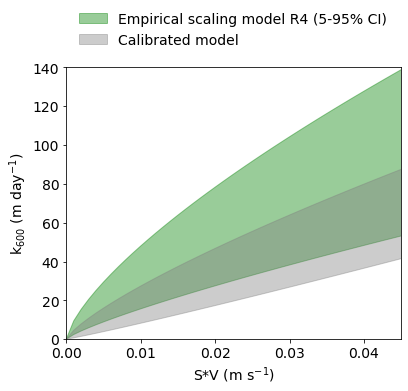

In [28]:
## plot optimized k600

plt.rcParams.update({'font.size': 14,
                    'lines.markersize':10,
                    'lines.markeredgewidth':2})


fig,ax=plt.subplots(1,1,figsize=(6,5))

svrange = [np.min(df['velocity']*-df['slope']),np.max(df['velocity']*-df['slope'])]
plotx = np.arange(svrange[0],svrange[1],0.001)

# plot Raymond et al., (2012) range of k600 vs. SV
low = plotx**(0.76+0.027*2) * (951.5-144*2)
high=plotx**(0.76-0.027*2) * (951.5+144*2)
plt.fill_between(plotx,high,low,color='green',alpha=0.4)


# find min and max for all optimized parameter sets
tempmin = np.zeros(len(plotx))*np.nan
tempmax = np.zeros(len(plotx))*np.nan

for i in best.index:
    if i==best.index[0]:
        label = 'l'
    else:
        label='_nolegend_'
        
    tempy = best.loc[i,'a']*(plotx)**best.loc[i,'b']
    
    tempmin = np.nanmin(np.array([tempmin,tempy]),0)
    tempmax = np.nanmax(np.array([tempmax,tempy]),0)
    
plt.fill_between(plotx,tempmax,tempmin,color='gray',alpha=0.4)

plt.legend(['Empirical scaling model R4 (5-95% CI)','Calibrated model'],loc='upper left',frameon=False,bbox_to_anchor=[0,1.25])
    
ax.set_xlim([0,0.045])
ax.set_ylim([0,140])

ax.set_xlabel('S*V (m s$^{-1}$)')
ax.set_ylabel('k$_{600}$ (m day$^{-1}$)')

    
fig.savefig('plots/Fig6_test2_k600_compare.pdf',bbox_inches='tight')

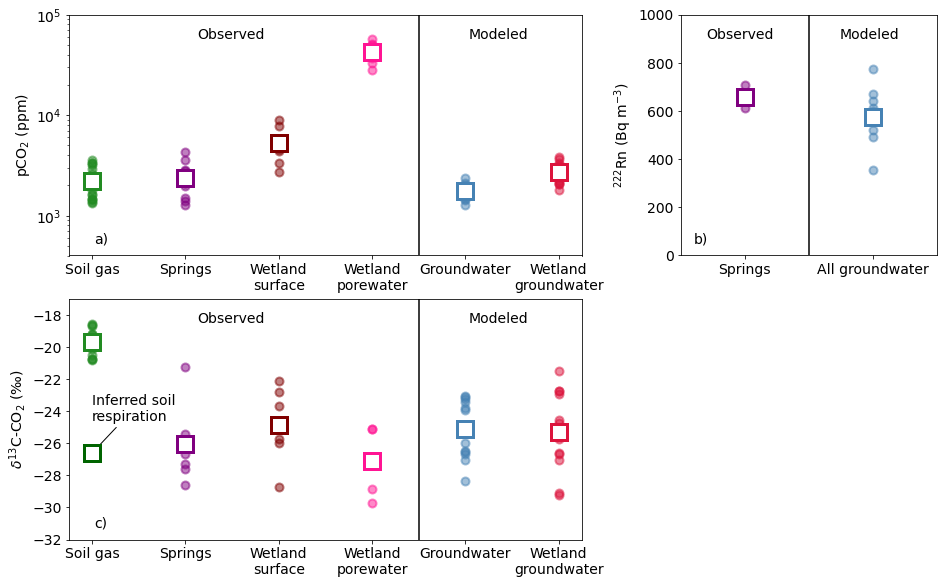

In [11]:
## okay evaluate measured candidate sources vs. optimized sources
plt.rcParams.update({'font.size': 14,
                    'lines.markersize':8,
                    'lines.markeredgewidth':2})


colors= ['darkblue','purple','deeppink','maroon','forestgreen','steelblue','crimson']

# read in soil data
soil = pd.read_csv('data/soil_gas.csv')

# do keeling plot to get inferred source soil CO2
x = 1/soil['pCO2_ppmv']
y = soil['d13C_permil']
nanmask = np.isnan(x) | np.isnan(y)
res = stats.linregress(x[~nanmask],y[~nanmask]) # will use the intercept (res[1]) later

gs_kw = dict(width_ratios=[2, 1], height_ratios=[1, 1])
# fig,ax=plt.subplots(2,2,figsize=(10,8),constrained_layout=True,sharex=True,gridspec=gs_kw)
fig,ax=plt.subplot_mosaic([[0,1],
                           [2,3]],
                          gridspec_kw=gs_kw, figsize=(13,8),
                          layout="constrained")


# plot soil gas
ax[0].plot(['Soil gas']*len(soil),soil['pCO2_ppmv'],c='forestgreen',alpha=0.5,marker='o',ls='')
ax[0].plot(['Soil gas'],np.mean(soil['pCO2_ppmv']),marker='s',markeredgecolor='forestgreen',markerfacecolor='white',markersize=16,markeredgewidth=3)
ax[2].plot(['Soil gas']*len(soil),soil['d13C_permil'],c='forestgreen',alpha=0.5,marker='o',ls='')
ax[2].plot(['Soil gas'],np.mean(soil['d13C_permil']),marker='s',markeredgecolor='forestgreen',markerfacecolor='white',markersize=16,markeredgewidth=3)
# intercept of Keeling plot -4.4 per mil fractionation for diffusion 
ax[2].errorbar('Soil gas',res.intercept-4.4,yerr=res.intercept_stderr,marker='s',c='darkgreen',markerfacecolor='white',markersize=16,markeredgewidth=3)
ax[2].annotate(f'Inferred soil\nrespiration',xy=['Soil gas',res.intercept-4.4],xytext=[0,res.intercept-4.4+2],arrowprops=dict(arrowstyle= '-',color='k'),zorder=0)

# springs
ax[0].plot(['Springs']*len(springs),springs['pco2'],c=colors[1],alpha=0.5,marker='o',ls='')
ax[0].plot(['Springs'],np.nanmean(springs['pco2']),marker='s',markeredgecolor=colors[1],markerfacecolor='white',markersize=16,markeredgewidth=3)
ax[2].plot(['Springs']*len(springs),springs['d13c_co2'],c=colors[1],alpha=0.5,marker='o',ls='')
ax[2].plot(['Springs'],np.nanmean(springs['d13c_co2']),marker='s',markeredgecolor=colors[1],markerfacecolor='white',markersize=16,markeredgewidth=3)
# Rn too 
ax[1].plot(['Springs']*len(springs['Rn_bq_m3']),springs['Rn_bq_m3'],c=colors[1],alpha=0.5,marker='o',ls='')
ax[1].plot(['Springs'],np.nanmean(springs['Rn_bq_m3']),marker='s',markeredgecolor=colors[1],markerfacecolor='white',markersize=16,markeredgewidth=3)

# wetlands
ax[0].plot(['Wetland\nsurface']*len(ponds),ponds['pco2'],c=colors[3],alpha=0.5,marker='o',ls='')
ax[0].plot(['Wetland\nsurface'],np.mean(ponds['pco2']),marker='s',markeredgecolor=colors[3],markerfacecolor='white',markersize=16,markeredgewidth=3)
ax[2].plot(['Wetland\nsurface']*len(ponds),ponds['d13c_co2'],c=colors[3],alpha=0.5,marker='o',ls='')
ax[2].plot(['Wetland\nsurface'],np.mean(ponds['d13c_co2']),marker='s',markeredgecolor=colors[3],markerfacecolor='white',markersize=16,markeredgewidth=3)

# wetland porewater
ax[0].plot(['Wetland\nporewater']*len(pzs),pzs['pco2'],c=colors[2],alpha=0.5,marker='o',ls='')
ax[0].plot(['Wetland\nporewater'],np.mean(pzs['pco2']),marker='s',markeredgecolor=colors[2],markerfacecolor='white',markersize=16,markeredgewidth=3)
ax[2].plot(['Wetland\nporewater']*len(pzs),pzs['d13c_co2'],c=colors[2],alpha=0.5,marker='o',ls='')
ax[2].plot(['Wetland\nporewater'],np.mean(pzs['d13c_co2']),marker='s',markeredgecolor=colors[2],markerfacecolor='white',markersize=16,markeredgewidth=3)

# modeled groundwater 
ax[0].plot(['Groundwater']*len(best),best['gw_pco2'],alpha=0.5,marker='o',ls='',c=colors[5])
ax[0].plot(['Groundwater'],np.nanmean(best['gw_pco2']),marker='s',markeredgecolor=colors[5],markerfacecolor='white',markersize=16,markeredgewidth=3)
ax[0].plot(['Wetland\ngroundwater']*len(best),best['wet_pco2'],alpha=0.5,marker='o',ls='',c=colors[6])
ax[0].plot(['Wetland\ngroundwater'],np.nanmean(best['wet_pco2']),marker='s',markeredgecolor=colors[6],markerfacecolor='white',markersize=16,markeredgewidth=3)
ax[2].plot(['Groundwater']*len(best),best['gw_d13c_co2'],alpha=0.5,marker='o',ls='',c=colors[5])
ax[2].plot(['Groundwater'],np.nanmean(best['gw_d13c_co2']),marker='s',markeredgecolor=colors[5],markerfacecolor='white',markersize=16,markeredgewidth=3)
ax[2].plot(['Wetland\ngroundwater']*len(best),best['wet_d13c_co2'],alpha=0.5,marker='o',ls='',c=colors[6])
ax[2].plot(['Wetland\ngroundwater'],np.nanmean(best['wet_d13c_co2']),marker='s',markeredgecolor=colors[6],markerfacecolor='white',markersize=16,markeredgewidth=3)
# Rn too
ax[1].plot(['All groundwater']*len(best),best['gw_rn'],alpha=0.5,marker='o',ls='',c=colors[5])
ax[1].plot(['All groundwater'],np.nanmean(best['gw_rn']),marker='s',markeredgecolor=colors[5],markerfacecolor='white',markersize=16,markeredgewidth=3)

# adjust axes
ax[0].set_yscale('log')
ax[0].set_ylim([400,100000])
ax[1].set_xlim([-0.5,1.5])
ax[1].set_ylim([0,1000])
ax[2].set_ylim([-32,-17])
ax[3].axis('off')

# make lines to separate plot sections
ax[0].axvline(3.5,c='k',ls='-')
ax[1].axvline(0.5,c='k',ls='-')
ax[2].axvline(3.5,c='k',ls='-')

# labels
ax[0].set_ylabel('pCO$_{2}$ (ppm)')
ax[1].set_ylabel('$^{222}$Rn (Bq m$^{-3}$)')
ax[2].set_ylabel(r'$\delta^{13}$C-CO$_{2}$ ($\perthousand$)')

# more labels
ax[0].text(0.25,0.9,'Observed',transform=ax[0].transAxes)
ax[0].text(0.78,0.9,'Modeled',transform=ax[0].transAxes)
ax[1].text(0.10,0.9,'Observed',transform=ax[1].transAxes)
ax[1].text(0.62,0.9,'Modeled',transform=ax[1].transAxes)
ax[2].text(0.25,0.9,'Observed',transform=ax[2].transAxes)
ax[2].text(0.78,0.9,'Modeled',transform=ax[2].transAxes)
ax[0].text(0.05,0.05,'a)',transform=ax[0].transAxes)
ax[1].text(0.05,0.05,'b)',transform=ax[1].transAxes)
ax[2].text(0.05,0.05,'c)',transform=ax[2].transAxes)

fig.savefig('plots/Fig7_sourceeval.pdf',facecolor='white', transparent=False)

In [13]:
### okay, so we have all the best optimized parameter sets...
### but, I didn't save the "full outputs" of all 30,000 MC iterations, so we have go back and get those
### and add Test 2a (clip) and Test 2b (no wetlands)
## this takes a long time to run :0
bestresults = pd.DataFrame()
bestresults_clip = pd.DataFrame()
bestresults_nowet = pd.DataFrame()
bestresults_sample = pd.DataFrame()

map_pco2s = np.empty([len(best.index),len(df)])
map_rns = np.empty([len(best.index),len(df)])
map_fco2s_area = np.empty([len(best.index),len(df)])
map_fco2s = np.empty([len(best.index),len(df)])

## this for loop iterates through all of the accepted model runs
# we want to extract the "results" summary including total flux, etc. for Table 4
# we also want to extract the spatial pco2 and fco2 values so that we can map the mean or median for each cell in Figure 8
for i,val in enumerate(best.index):

    [results,df_iter] = networkmodel_notmc(best.loc[val,['a','b','gw_DIC','wet_DIC','gw_d13c_co2','wet_d13c_co2','gw_rn']],clip=False)
    
    results['index'] = val
    results = results.set_index('index')
    
    tempdf_sample = df_iter.loc[~df_iter['pco2_meas'].isna(),:]
    tempdf_sample.loc[:,'index'] = val
    
    bestresults = pd.concat([bestresults,results])
    bestresults_sample = pd.concat([bestresults_sample,tempdf_sample])
    
    [results_nowet,df_iter_nowet] = networkmodel_notmc(best.loc[val,['a','b','gw_DIC','gw_DIC','gw_d13c_co2','gw_d13c_co2','gw_rn']],
                                                 clip=False)
    [results_clip,df_iter_clip] = networkmodel_notmc(best.loc[val,['a','b','gw_DIC','wet_DIC','gw_d13c_co2','wet_d13c_co2','gw_rn']],
                                                     clip=True)
    
    results_nowet['index'] = val
    results_nowet = results_nowet.set_index('index')
    
    results_clip['index'] = val
    results_clip = results_clip.set_index('index')
    
    bestresults_clip = pd.concat([bestresults_clip,results_clip])
    bestresults_nowet = pd.concat([bestresults_nowet,results_nowet])
    
    map_pco2s[i,:] = df_iter['pco2_mod'].to_numpy()
    map_rns[i,:] = df_iter['rn'].to_numpy()
    map_fco2s_area[i,:] = df_iter['fco2_perarea'].to_numpy()
    map_fco2s[i,:] = df_iter['fco2'].to_numpy()

In [14]:
## compare reduction of CO2 emissions for nowet and clip scenarios
nowet_reduction = 1-np.nanmean(bestresults_nowet['fco2'])/np.nanmean(bestresults['fco2'])
clip_reduction = 1-np.nanmean(bestresults_clip['fco2']/np.nanmean(bestresults['fco2']))

print('On average,')
print(f'Removing wetlands (setting pCO2 to regular gw) reduced total CO2 flux by {round(nowet_reduction*100,1)}%')
print(f'Clipping headwaters reduced total CO2 flux by {round(clip_reduction*100,1)}%')

On average,
Removing wetlands (setting pCO2 to regular gw) reduced total CO2 flux by 19.3%
Clipping headwaters reduced total CO2 flux by 17.0%


In [15]:
### the "wetland DIC" is really just the DIC of the inflowing water for wetland-bounded grid cells
## it doesnt necessarily need to represent wetland porewater, for exampe
# let's compare the "wetland DIC" with other sources
bestresults['wet_DIC']

pz_dic = 2.79/1000 # mean from table 1

mixing = (bestresults['wet_DIC']-bestresults['gw_DIC'])/(pz_dic-bestresults['gw_DIC'])

p_dic = 0.9/1000 # mean from table 2

mixing2 = (bestresults['wet_DIC']-bestresults['gw_DIC'])/(p_dic-bestresults['gw_DIC'])

### if "wetland groundwater" is a mixture of regular groundwater and piezometer sampled porewater, what fraction porewater is it?
print('if "wetland groundwater" is a mixture of regular groundwater and piezometer sampled porewater, what fraction porewater is it?')
print(np.min(mixing*100))
print(np.mean(mixing*100))
print(np.max(mixing*100))

print('if "wetland groundwater" is a mixture of regular groundwater and ponded wetland samples, what fraction porewater is it?')

print(round(np.min(mixing2*100),2))
print(round(np.mean(mixing2*100),2))
print(round(np.max(mixing2*100),2))

if "wetland groundwater" is a mixture of regular groundwater and piezometer sampled porewater, what fraction porewater is it?
0.010524368180633925
2.4245937328940124
5.600734026805679
if "wetland groundwater" is a mixture of regular groundwater and ponded wetland samples, what fraction porewater is it?
0.05
12.06
27.23


In [16]:
## table 4 to compare Test 1, 2.... 
# read Test 1
test1df = pd.read_csv('modeloutputs/test1_results.csv',index_col=0)
# this is the mean fco2 of model runs using reported k600 relationships and mean gw DIC
test1mean = np.mean(test1df.loc[((test1df['gw_used']=='mean')&(test1df['k600_used'].isin(['ulseth','r1','r2','r3','r4','r5','r6','r7']))),'fco2'])/1e6

# define outlet (site 23)
outlet = df.loc[df['sample_name']=='ER23-23',:]

## mg C /L *1g/1000mg* m3/s * 1000 L/m3s *  *24*60*60 s/day
outlet_dicflux =(outlet['dic_calc'].item()*12/1e6)*outlet['discharge'].item()*1000*24*60*60
outlet_docflux = (outlet['DOC_mg_L'].item()/1000)*outlet['discharge'].item()*1000*24*60*60
degassingflux = np.mean(best['fco2'])

total_cflux = outlet_dicflux+outlet_docflux+degassingflux
dic_meas_error = 0.069 #6.9%
dic_meas_error = 30.54312/outlet['dic_calc'].item() #30.54312 is the DIC error (in co2sys script)
doc_meas_error = 0.05 #5%

## conroy outlet DIC 16 mg/L, DOC 3.8 mg/L, discharge 1.9 m3/s
conroy_dic_meas_error = 1.565872804/1000 *1.9*1000*24*60*60

conroy_dicflux= 16.00185799/1000 *1.9*1000*24*60*60
conroy_docflux= 3.8/1000 *1.9*1000*24*60*60
# conroy degassing flux was 1.22 (1.03-1.47)
conroy_degassingflux = 1.22

# august outlet discharge was 5e-3
conroy_degassingflux2 = 0.034
conroy_dicflux2 = 14.9380876/1000*5e-3*1000*24*60*60
conroy_docflux2 = 0.056/1000*5e-3*1000*24*60*60
conroy_total_cflux = conroy_dicflux/1e6+conroy_docflux/1e6+conroy_degassingflux
conroy_total_cflux2 = conroy_dicflux2/1e6+conroy_docflux2/1e6+conroy_degassingflux2

#### Solano et al
# in gC / s
solano_dicflux = 7.75/1e6 * 3600*24
solano_docflux = 2.99/1e6*3600*24
# co2 flux was 1.86 by k600 and 1.36 by chamber
solano_co2flux = 1.86/1e6*3600*24
solano_total_cflux = solano_dicflux+solano_docflux+solano_co2flux

print('What fraction of total aquatic C is from CO2 evasion, DIC and DOC outlet fluxes?')
print('For Little Deschutes (Just June 2023)')
print(f'CO2 flux is {100*round(degassingflux/total_cflux,2)}%')
print(f'DIC flux is {100*round(outlet_dicflux/total_cflux,2)}%')
print(f'DOC flux is {100*round(outlet_docflux/total_cflux,2)}%')

print(f'BUT total C flux per unit area is {round(total_cflux/1e6/46,2)} gC / m^2 / d')


print('For Martha Creek (just June 2021)')
print(f'CO2 flux is {100*round(conroy_degassingflux2/conroy_total_cflux2,2)}%')
print(f'DIC flux is {100*round(conroy_dicflux2/1e6/conroy_total_cflux2,2)}%')
print(f'DOC flux is {100*round(conroy_docflux2/1e6/conroy_total_cflux2,6)}%')

print(f'and total C flux per unit area is {round(conroy_total_cflux2/6,2)} gC / m^2 / d')


print('For Martha Creek (November 2021)')
print(f'CO2 flux is {100*round(conroy_degassingflux/conroy_total_cflux,2)}%')
print(f'DIC flux is {100*round(conroy_dicflux/1e6/conroy_total_cflux,2)}%')
print(f'DOC flux is {100*round(conroy_docflux/1e6/conroy_total_cflux,2)}%')

print(f'and total C flux per unit area is {round(conroy_total_cflux/6,2)} gC / m^2 / d')

print('For Manton Creek (ANNUAL AVERAGE)')
print(f'CO2 flux is {100*round(solano_co2flux/solano_total_cflux,2)}%')
print(f'DIC flux is {100*round(solano_dicflux/solano_total_cflux,2)}%')
print(f'DOC flux is {100*round(solano_docflux/solano_total_cflux,2)}%')

print(f'and total C flux per unit area is {round(solano_total_cflux/34,2)} gC / m^2 / d')

#### Wallin 2012: Krycklan  is 53% CO2 evasion, 7% DIC, 40% DOC

What fraction of total aquatic C is from CO2 evasion, DIC and DOC outlet fluxes?
For Little Deschutes (Just June 2023)
CO2 flux is 12.0%
DIC flux is 50.0%
DOC flux is 38.0%
BUT total C flux per unit area is 0.04 gC / m^2 / d
For Martha Creek (just June 2021)
CO2 flux is 84.0%
DIC flux is 16.0%
DOC flux is 0.0598%
and total C flux per unit area is 0.01 gC / m^2 / d
For Martha Creek (November 2021)
CO2 flux is 27.0%
DIC flux is 59.0%
DOC flux is 14.000000000000002%
and total C flux per unit area is 0.75 gC / m^2 / d
For Manton Creek (ANNUAL AVERAGE)
CO2 flux is 15.0%
DIC flux is 62.0%
DOC flux is 24.0%
and total C flux per unit area is 0.03 gC / m^2 / d


In [17]:
### Table 4

table4 = pd.DataFrame(columns=['Description','C flux'])

table4.loc[0,'Description'] = 'Model CO_{2} evasion flux (5-95\% CI):'
table4.loc[1,'Description'] = 'Test 1'
table4.loc[2,'Description'] = 'Calibrated CO2 evasion flux: mean (range):'

table4.loc[3,'Description'] = 'Test 2'
table4.loc[4,'Description'] = 'Test 2a: remove wetlands'
table4.loc[5,'Description'] = 'Test 2b: remove headwaters'


table4.loc[1,'C flux'] = f"{round(test1mean,3)} ({round(np.min(test1df['fco2']/1e6),3)}-{round(np.max(test1df['fco2']/1e6),3)})"
table4.loc[3,'C flux'] = f"{round(np.mean(bestresults['fco2']/1e6),3)} ({round(np.min(bestresults['fco2']/1e6),3)}-{round(np.max(bestresults['fco2']/1e6),3)})"
table4.loc[4,'C flux'] = f"{round(np.mean(bestresults_nowet['fco2']/1e6),3)} ({round(np.min(bestresults_nowet['fco2']/1e6),3)}-{round(np.max(bestresults_nowet['fco2']/1e6),3)})"
table4.loc[5,'C flux'] = f"{round(np.mean(bestresults_clip['fco2']/1e6),3)} ({round(np.min(bestresults_clip['fco2']/1e6),3)}-{round(np.max(bestresults_clip['fco2']/1e6),3)})"


table4.loc[6,'Description'] = 'Outlet C fluxes (5-95\% CI)'
table4.loc[7,'Description'] = 'DIC'
table4.loc[8,'Description'] = 'DOC'

table4.loc[7,'C flux'] = f"{round(outlet_dicflux/1e6,3)} ({round((outlet_dicflux-2*dic_meas_error*outlet_dicflux)/1e6,3)}-{round((outlet_dicflux+2*dic_meas_error*outlet_dicflux)/1e6,3)})"
table4.loc[8,'C flux'] = f"{round(outlet_docflux/1e6,3)} ({round((outlet_docflux-2*doc_meas_error*outlet_docflux)/1e6,3)}-{round((outlet_docflux+2*doc_meas_error*outlet_docflux)/1e6,3)})"


table4 = table4.rename(columns={'C flux':'C flux (Mg C day^{-1})'})


table4.to_csv('tables/Table4.csv')

table4

,Description,C flux (Mg C day^{-1})
0,Model CO_{2} evasion flux (5-95\% CI):,NaN
1,Test 1,0.253 (0.038-0.734)
2,Calibrated CO2 evasion flux: mean (range):,NaN
3,Test 2,0.209 (0.115-0.325)
4,Test 2a: remove wetlands,0.168 (0.103-0.291)
5,Test 2b: remove headwaters,0.173 (0.089-0.266)
6,Outlet C fluxes (5-95\% CI),NaN
7,DIC,0.902 (0.745-1.06)
8,DOC,0.694 (0.625-0.763)


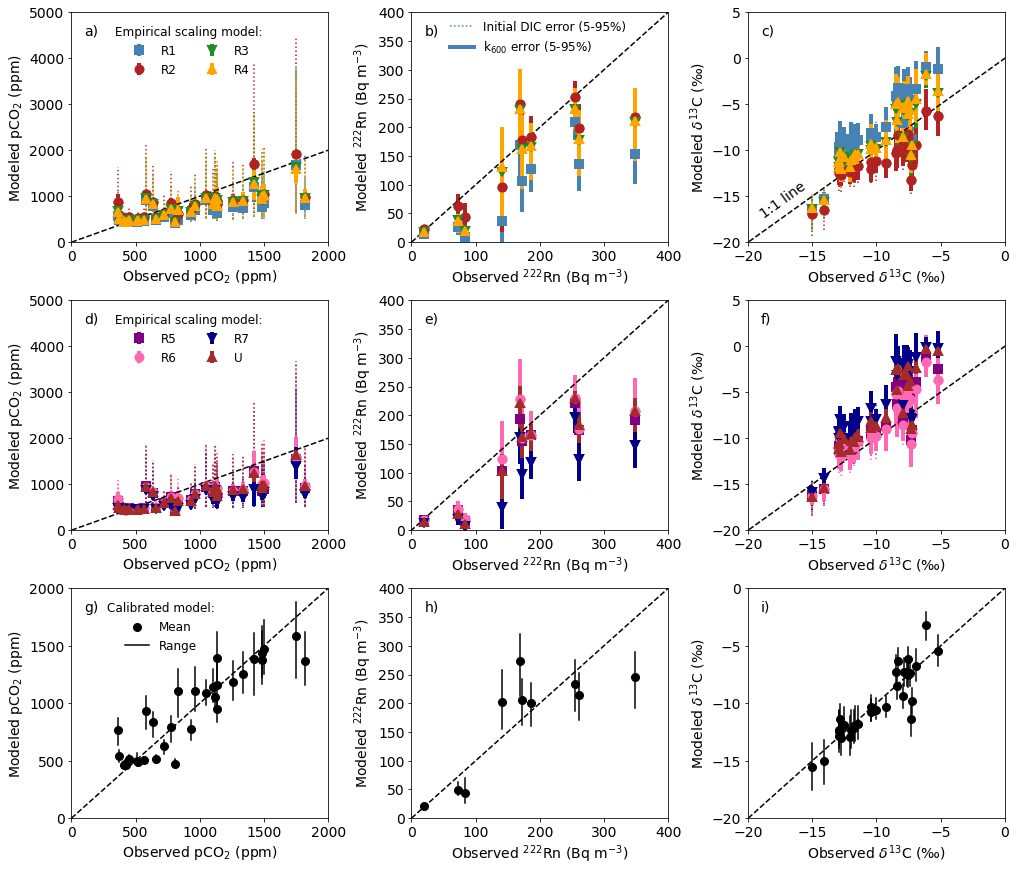

In [18]:
#### Now compare model - measurement performance across Test 1 and 2
plt.rcParams.update({'font.size': 14,
                    'lines.markersize':8,
                    'lines.markeredgewidth':2})

# read in test1 df
testdf_long = pd.read_csv('modeloutputs/test1_long.csv',index_col=0)
testdf_long1 = testdf_long.loc[testdf_long['gw_used']=='mean',:] # all mean gw, varying k600
klist_short = ['r1','r2','r3','r4','r5','r6','r7','ulseth']
testdf_long2 = testdf_long.loc[((testdf_long['k600_used'].isin(klist_short))&(testdf_long['gw_used']!='mean')),:] # all mean k600, varying gw


fig,ax = plt.subplots(3,3,figsize=(14,12),constrained_layout=True)
ax = ax.flatten()

markers = ['s','o','v','^','s','o','v','^']
# markers=['o','o','o','o','o','o','o','o','o','o']
colors = ['steelblue','firebrick','forestgreen','orange','purple','hotpink','darkblue','brown']


for i,k in enumerate(klist_short):
    tempx1 = testdf_long1.loc[testdf_long1['k600_used']==k,'pco2_meas']
    tempy1 = testdf_long1.loc[testdf_long1['k600_used']==k,'pco2_mod'].values

    tempy1_low=testdf_long1.loc[testdf_long1['k600_used']==k+'_low','pco2_mod']
    tempy1_high=testdf_long1.loc[testdf_long1['k600_used']==k+'_high','pco2_mod']
    
    tempy1_minus = tempy1-np.min([tempy1_low,tempy1_high],axis=0)
    tempy1_plus = np.max([tempy1_low,tempy1_high],axis=0)-tempy1
    
        
    tempx2 = testdf_long1.loc[testdf_long1['k600_used']==k,'rn_meas']
    tempy2 = testdf_long1.loc[testdf_long1['k600_used']==k,'rn'].values

    tempy2_low=testdf_long1.loc[testdf_long1['k600_used']==k+'_low','rn']
    tempy2_high=testdf_long1.loc[testdf_long1['k600_used']==k+'_high','rn']

    tempy2_minus = tempy2-np.min([tempy2_low,tempy2_high],axis=0)
    tempy2_plus = np.max([tempy2_low,tempy2_high],axis=0)-tempy2
    
    
    tempx3 = testdf_long1.loc[testdf_long1['k600_used']==k,'dic_delta_meas']
    tempy3 = testdf_long1.loc[testdf_long1['k600_used']==k,'dic_delta'].values

    tempy3_low=testdf_long1.loc[testdf_long1['k600_used']==k+'_low','dic_delta']
    tempy3_high=testdf_long1.loc[testdf_long1['k600_used']==k+'_high','dic_delta']

    tempy3_minus = tempy3-np.min([tempy3_low,tempy3_high],axis=0)
    tempy3_plus = np.max([tempy3_low,tempy3_high],axis=0)-tempy3

    tempy4_low=testdf_long2.loc[((testdf_long2['k600_used']==k)&(testdf_long2['gw_used']=='low')),'pco2_mod']
    tempy4_high=testdf_long2.loc[((testdf_long2['k600_used']==k)&(testdf_long2['gw_used']=='high')),'pco2_mod']

    tempy4_minus = tempy1-np.min([tempy4_low,tempy4_high],axis=0)
    tempy4_plus = np.max([tempy4_low,tempy4_high],axis=0)-tempy1
    
    tempy5_low=testdf_long2.loc[((testdf_long2['k600_used']==k)&(testdf_long2['gw_used']=='low')),'rn']
    tempy5_high=testdf_long2.loc[((testdf_long2['k600_used']==k)&(testdf_long2['gw_used']=='high')),'rn']

    tempy5_minus = tempy2-np.min([tempy5_low,tempy5_high],axis=0)
    tempy5_plus = np.max([tempy5_low,tempy5_high],axis=0)-tempy2
    
    tempy6_low=testdf_long2.loc[((testdf_long2['k600_used']==k)&(testdf_long2['gw_used']=='low')),'dic_delta']
    tempy6_high=testdf_long2.loc[((testdf_long2['k600_used']==k)&(testdf_long2['gw_used']=='high')),'dic_delta']

    tempy6_minus = tempy3-np.min([tempy3,tempy6_low,tempy6_high],axis=0)
    tempy6_plus = np.max([tempy3,tempy6_low,tempy6_high],axis=0)-tempy3
    
    
    
    if i<4:
        ax[0].errorbar(tempx1,tempy1,yerr=[tempy1_minus,tempy1_plus],ls='',marker=markers[i],c=colors[i],elinewidth=4)
        ax[1].errorbar(tempx2,tempy2,yerr=[tempy2_plus,tempy2_minus],ls='',marker=markers[i],c=colors[i],elinewidth=4)
        ax[2].errorbar(tempx3,tempy3,yerr=[tempy3_plus,tempy3_minus],ls='',marker=markers[i],c=colors[i],elinewidth=4)
        
        eb1=ax[0].errorbar(tempx1,tempy1,yerr=[tempy4_minus,tempy4_plus],ls='',marker=markers[i],c=colors[i],zorder=0,label='_nolegend_')         
        eb1[-1][0].set_linestyle(':')
        eb2=ax[1].errorbar(tempx2,tempy2,yerr=[tempy5_minus,tempy5_plus],ls='',marker=markers[i],c=colors[i],zorder=0,label='_nolegend_')         
        eb2[-1][0].set_linestyle(':')
        eb3=ax[2].errorbar(tempx3,tempy3,yerr=[tempy6_minus,tempy6_plus],ls='',marker=markers[i],c=colors[i],zorder=0,label='_nolegend_')         
        eb3[-1][0].set_linestyle(':')
        
    else:
        ax[3].errorbar(tempx1,tempy1,yerr=[tempy1_plus,tempy1_minus],ls='',marker=markers[i],c=colors[i],elinewidth=4)
        ax[4].errorbar(tempx2,tempy2,yerr=[tempy2_plus,tempy2_minus],ls='',marker=markers[i],c=colors[i],elinewidth=4)
        ax[5].errorbar(tempx3,tempy3,yerr=[tempy3_plus,tempy3_minus],ls='',marker=markers[i],c=colors[i],elinewidth=4)
    
        eb1=ax[3].errorbar(tempx1,tempy1,yerr=[tempy4_minus,tempy4_plus],ls='',marker=markers[i],c=colors[i],zorder=0,label='_nolegend_')         
        eb1[-1][0].set_linestyle(':')
        eb2=ax[4].errorbar(tempx2,tempy2,yerr=[tempy5_minus,tempy5_plus],ls='',marker=markers[i],c=colors[i],zorder=0,label='_nolegend_')         
        eb2[-1][0].set_linestyle(':')
        eb3=ax[5].errorbar(tempx3,tempy3,yerr=[tempy6_minus,tempy6_plus],ls='',marker=markers[i],c=colors[i],zorder=0,label='_nolegend_')         
        eb3[-1][0].set_linestyle(':')


  
ax[0].set_xlabel('Observed pCO$_{2}$ (ppm)')
ax[0].set_ylabel('Modeled pCO$_{2}$ (ppm)')

ax[1].set_xlabel(r'Observed $^{222}$Rn (Bq m$^{-3}$)')
ax[1].set_ylabel(r'Modeled $^{222}$Rn (Bq m$^{-3}$)')

ax[2].set_xlabel(r'Observed $\delta^{13}$C (‰)')
ax[2].set_ylabel(r'Modeled $\delta^{13}$C (‰)')


ax[3].set_xlabel('Observed pCO$_{2}$ (ppm)')
ax[3].set_ylabel('Modeled pCO$_{2}$ (ppm)')

ax[4].set_xlabel(r'Observed $^{222}$Rn (Bq m$^{-3}$)')
ax[4].set_ylabel(r'Modeled $^{222}$Rn (Bq m$^{-3}$)')

ax[5].set_xlabel(r'Observed $\delta^{13}$C (‰)')
ax[5].set_ylabel(r'Modeled $\delta^{13}$C (‰)')

ax[0].legend(['R1','R2','R3','R4'],frameon=False,fontsize=12,loc=[0.15,0.7],title='Empirical scaling model:',ncol=2,title_fontsize=12)
ax[3].legend(['R5','R6','R7','U'],frameon=False,fontsize=12,loc=[0.15,0.7],title='Empirical scaling model:',ncol=2,title_fontsize=12)


legenditems = [Line2D([0], [0], label='Initial DIC error (5-95%)', color=colors[0],ls=':'),
              Line2D([0], [0], label='k$_{600}$ error (5-95%)', color=colors[0],ls='-',lw=4)]
ax[1].legend(handles=legenditems,frameon=False,fontsize=12,loc=[0.13,0.79])

ax[0].plot([0,6600],[0,6600],c='k',ls='--')
ax[1].plot([0,400],[0,400],c='k',ls='--')
ax[2].plot([-29,3],[-29,3],c='k',ls='--')

ax[3].plot([0,6600],[0,6600],c='k',ls='--')
ax[4].plot([-20,400],[-20,400],c='k',ls='--')
ax[5].plot([-29,3],[-29,3],c='k',ls='--')



##### now the MC results
for i in set(bestresults_sample['sample_name']):

    y1min = np.min(bestresults_sample.loc[bestresults_sample['sample_name']==i,'pco2_mod'])
    y1med = np.mean(bestresults_sample.loc[bestresults_sample['sample_name']==i,'pco2_mod'])
    y1max = np.max(bestresults_sample.loc[bestresults_sample['sample_name']==i,'pco2_mod'])
    
    y1lower = np.percentile(bestresults_sample.loc[bestresults_sample['sample_name']==i,'pco2_mod'],5)
    y1upper = np.percentile(bestresults_sample.loc[bestresults_sample['sample_name']==i,'pco2_mod'],95)

    x1 = bestresults_sample.loc[bestresults_sample['sample_name']==i,'pco2_meas'].values[0]    
    
    y2min = np.min(bestresults_sample.loc[bestresults_sample['sample_name']==i,'rn'])
    y2med = np.mean(bestresults_sample.loc[bestresults_sample['sample_name']==i,'rn'])
    y2max = np.max(bestresults_sample.loc[bestresults_sample['sample_name']==i,'rn'])

    y2lower = np.percentile(bestresults_sample.loc[bestresults_sample['sample_name']==i,'rn'],5)
    y2upper = np.percentile(bestresults_sample.loc[bestresults_sample['sample_name']==i,'rn'],95)

    x2 = bestresults_sample.loc[bestresults_sample['sample_name']==i,'rn_meas'].values[0]
    
    y3min = np.min(bestresults_sample.loc[bestresults_sample['sample_name']==i,'dic_delta'])
    y3med = np.mean(bestresults_sample.loc[bestresults_sample['sample_name']==i,'dic_delta'])
    y3max = np.max(bestresults_sample.loc[bestresults_sample['sample_name']==i,'dic_delta'])
    y3lower = np.percentile(bestresults_sample.loc[bestresults_sample['sample_name']==i,'dic_delta'],5)
    y3upper = np.percentile(bestresults_sample.loc[bestresults_sample['sample_name']==i,'dic_delta'],95)

    x3 = bestresults_sample.loc[bestresults_sample['sample_name']==i,'dic_delta_meas'].values[0]
    
    ax[6].scatter(x1,y1med,c='k')
    ax[7].scatter(x2,y2med,c='k')
    ax[8].scatter(x3,y3med,c='k')
    
    ax[6].plot([x1,x1],[y1lower,y1upper],c='k')
    ax[7].plot([x2,x2],[y2lower,y2upper],c='k')
    ax[8].plot([x3,x3],[y3lower,y3upper],c='k')


# 1:1 lines
ax[6].plot([0,3600],[0,3600],c='k',ls='--')
ax[7].plot([0,400],[0,400],c='k',ls='--')
ax[8].plot([-20,5],[-20,5],c='k',ls='--')

# plot adjustments
ax[0].set_xlim([0,2000])
ax[1].set_xlim([0,400])
ax[2].set_xlim([-20,0])

ax[3].set_xlim([0,2000])
ax[4].set_xlim([0,400])
ax[5].set_xlim([-20,0])

ax[0].set_ylim([0,5000])
ax[1].set_ylim([0,400])
ax[2].set_ylim([-20,5])

ax[3].set_ylim([0,5000])
ax[4].set_ylim([0,400])
ax[5].set_ylim([-20,5])

ax[6].set_xlim([0,2000])
ax[7].set_xlim([0,400])
ax[8].set_xlim([-20,0])
ax[6].set_ylim([0,2000])
ax[6].set_yticks([0,500,1000,1500,2000])
ax[7].set_ylim([0,400])
ax[8].set_ylim([-20,0])

# re do ticks
ax[8].set_yticks([-20,-15,-10,-5,0])
    
# labels
ax[6].set_xlabel('Observed pCO$_{2}$ (ppm)')
ax[6].set_ylabel('Modeled pCO$_{2}$ (ppm)')

ax[7].set_xlabel(r'Observed $^{222}$Rn (Bq m$^{-3}$)')
ax[7].set_ylabel(r'Modeled $^{222}$Rn (Bq m$^{-3}$)')

ax[8].set_xlabel(r'Observed $\delta^{13}$C (‰)')
ax[8].set_ylabel(r'Modeled $\delta^{13}$C (‰)')

letters = ['a)','b)','c)','d)','e)','f)','g)','h)','i)','j)']

[ax[i].text(0.05,0.90,letters[i],transform=ax[i].transAxes) for i in range(0,9)]

ax[6].legend(['Mean','Range'],frameon=False,loc=[0.12,0.7],title='Calibrated model:',fontsize=12,title_fontsize=12)

# make a tilted 1:1 line label
xyfrom = [-18,-18]
xyto = [-15,-15]

midx = -17
midy=-16

text = '1:1 line'

dx = xyto[0] - xyfrom[0]
dy = xyto[1] - xyfrom[1]
rotn = np.degrees(np.arctan2(dy, dx)) # not the transformed p2 and p1

ax[2].text(midx, midy, text, ha='center', va='bottom', color='k',
        rotation=rotn, rotation_mode='anchor', transform_rotates_text=True)


fig.savefig('plots/Fig5_tests_evaluate.pdf')

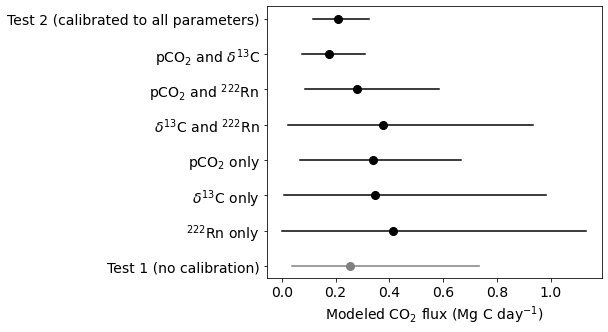

In [19]:
#### make a plot comparing the range of co2 fluxes depending on how we calibrate

fig,ax=plt.subplots(1,1,figsize=(6,5))

co2_best = mcresults['rmse_pco2']/np.nanmean(streams['pCO2_ppmv'])<0.24
iso_best = mcresults['rmse_d13c']<1.647
rn_best = mcresults['rmse_rn']/np.nanmean(streams['Rn_bq_m3'])<0.42


best_a = mcresults.loc[co2_best,:]
best_b = mcresults.loc[iso_best,:]
best_c = mcresults.loc[rn_best,:]

best_ab = mcresults.loc[(iso_best & co2_best),:]
best_ac = mcresults.loc[(co2_best &  rn_best),:]
best_bc = mcresults.loc[(iso_best & rn_best),:]

labels = ['Test 2 (calibrated to all parameters)','pCO$_{2}$ and $\delta^{13}$C','pCO$_{2}$ and $^{222}$Rn','$\delta^{13}$C and $^{222}$Rn',
          'pCO$_{2}$ only','$\delta^{13}$C only','$^{222}$Rn only','Test 1 (no calibration)']

ax.plot([np.min(best['fco2']/1e6),np.max(best['fco2']/1e6)],[labels[0],labels[0]],c='k')
ax.plot([np.min(best_ab['fco2']/1e6),np.max(best_ab['fco2']/1e6)],[labels[1],labels[1]],c='k')
ax.plot([np.min(best_ac['fco2']/1e6),np.max(best_ac['fco2']/1e6)],[labels[2],labels[2]],c='k')
ax.plot([np.min(best_bc['fco2']/1e6),np.max(best_bc['fco2']/1e6)],[labels[3],labels[3]],c='k')
ax.plot([np.min(best_a['fco2']/1e6),np.max(best_a['fco2']/1e6)],[labels[4],labels[4]],c='k')
ax.plot([np.min(best_b['fco2']/1e6),np.max(best_b['fco2']/1e6)],[labels[5],labels[5]],c='k')
ax.plot([np.min(best_c['fco2']/1e6),np.max(best_c['fco2']/1e6)],[labels[6],labels[6]],c='k')
ax.plot([np.min(test1df['fco2']/1e6),np.max(test1df['fco2']/1e6)],[labels[7],labels[7]],c='gray')

ax.scatter(np.mean(best['fco2']/1e6),[labels[0]],c='k')
ax.scatter(np.mean(best_ab['fco2']/1e6),[labels[1]],c='k')
ax.scatter(np.mean(best_ac['fco2']/1e6),[labels[2]],c='k')
ax.scatter(np.mean(best_bc['fco2']/1e6),[labels[3]],c='k')
ax.scatter(np.mean(best_a['fco2']/1e6),[labels[4]],c='k')
ax.scatter(np.mean(best_b['fco2']/1e6),[labels[5]],c='k')
ax.scatter(np.mean(best_c['fco2']/1e6),[labels[6]],c='k')
ax.scatter(test1mean,[labels[7]],c='gray')


ax.set_xlabel('Modeled CO$_{2}$ flux (Mg C day$^{-1}$)')

plt.gca().invert_yaxis()

fig.savefig('plots/FigS7_flux_calibration.pdf',bbox_inches='tight')

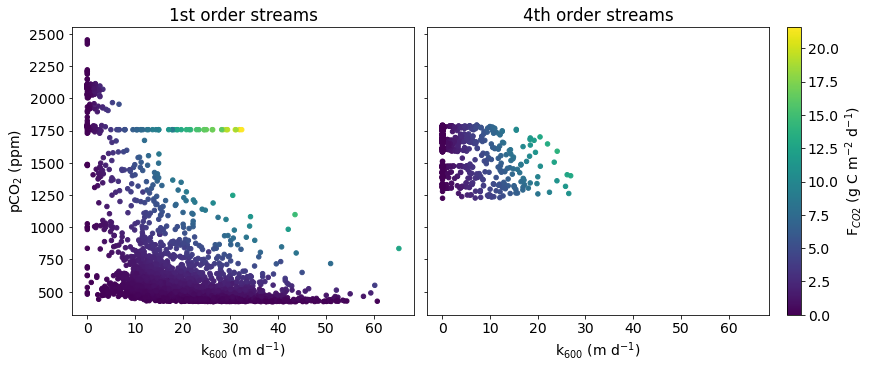

In [20]:
fig,ax=plt.subplots(1,2,figsize=(12,5),constrained_layout=True,sharex=True,sharey=True)

df_bestest = df_iter # just get the network data from the last iteration
tempdf = df_bestest.loc[df_bestest['strahler']==1,:]

# scaling the colorbar
vmin=0
vmax = np.max(df_bestest['fco2_perarea'])
cbar = ax[0].scatter(tempdf['k600_mc'],tempdf['pco2_mod'].shift(1),c=tempdf['fco2_perarea'],s=20,vmin=vmin,vmax=vmax)
# shift pco2, because we matched co2 from the last cell with the k600 of current cell to calculate fco2 for current cell

plt.colorbar(cbar,label='F$_{CO2}$ (g C m$^{-2}$ d$^{-1}$)',ax=ax[1])


tempdf = df_bestest.loc[df_bestest['strahler']==4,:]
cbar = ax[1].scatter(tempdf['k600_mc'],tempdf['pco2_mod'].shift(1),c=tempdf['fco2_perarea'],s=20,vmin=vmin,vmax=vmax)


ax[0].set_xlabel('k$_{600}$ (m d$^{-1}$)')
ax[1].set_xlabel('k$_{600}$ (m d$^{-1}$)')
ax[0].set_ylabel('pCO$_{2}$ (ppm)')

ax[0].set_title('1st order streams')
ax[1].set_title('4th order streams')

fig.savefig('plots/test2_fco2_biplots.pdf')

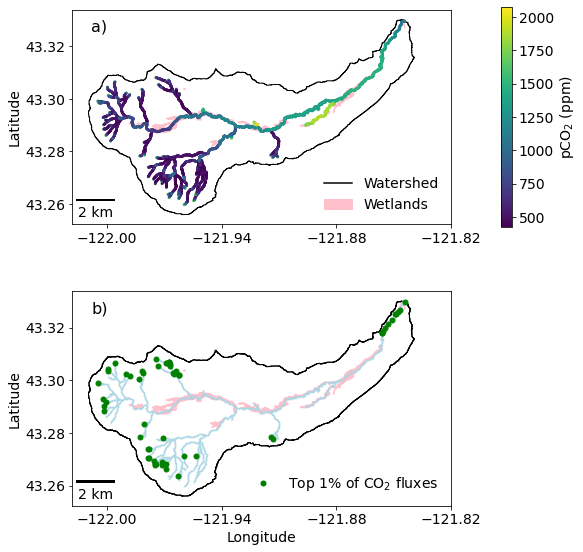

In [27]:
# last plot: map of model results
plt.rcParams.update({'font.size': 14,
                    'lines.markersize':10,
                    'lines.markeredgewidth':2})



fig,ax=plt.subplots(2,1,figsize=(8,8),constrained_layout=True)

# mean pco2 and fco2 from calibrated models
map_pco2_mean = np.nanmean(map_pco2s,0)

# nans in fco2 for channel heads that havent degassed yet
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    map_fco2_area_mean = np.nanmean(map_fco2s_area,0)
    map_fco2_mean = np.nanmean(map_fco2s,0)

# color bar for pco2
cbar1 = ax[0].scatter(df['longitude'],df['latitude'],c=map_pco2_mean,s=3,cmap='viridis')
plt.colorbar(cbar1,label='pCO$_{2}$ (ppm)',shrink=0.8)

# hotspots where flux is greater than 99%
hotspots_area = df.loc[map_fco2_area_mean >np.nanpercentile(map_fco2_area_mean ,99),:]
hotspots = df.loc[map_fco2_mean >np.nanpercentile(map_fco2_mean ,99),:]


ax[1].scatter(df['longitude'],df['latitude'],c='lightblue',s=0.1)
ax[1].scatter(hotspots_area['longitude'],hotspots_area['latitude'],c='green',s=25)

# plot watershed outline
watershed = gpd.read_file('map/watershed_area_vector.shp')
watershed.plot(ax = ax[1], color = 'none', edgecolor = 'k',zorder=0,lw=1)
watershed.plot(ax = ax[0], color = 'none', edgecolor = 'k',zorder=0,lw=1)
watershed.plot(ax = ax[1], color = 'none', edgecolor = 'k',zorder=0,lw=1)
# plot wetlands
wetland = gpd.read_file('map/wetlands_buffer.shp')
wetland_clipped = wetland.clip(watershed)
wetland_clipped.plot(ax = ax[1], color = 'pink', edgecolor = 'pink',zorder=0)
wetland_clipped.plot(ax = ax[0], color = 'pink', edgecolor = 'pink',zorder=0)

## add scale bar from https://geopandas.org/en/stable/gallery/matplotlib_scalebar.html
### IMPORTANT: dx argument here is "dx should be equal to a distance in meters of two points with the same 
### latitude (Y coordinate) which are one full degree of longitude (X) apart"
points = gpd.GeoSeries(
    [Point(-121, 43.3), Point(-122, 43.3)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)
distance_meters = points[0].distance(points[1])

ax[0].add_artist(ScaleBar(distance_meters,location='lower left'))
ax[1].add_artist(ScaleBar(distance_meters,location='lower left'))

# axis adjust
ax[0].set_xticks(np.linspace(-122.0,-121.82,4))
ax[1].set_xticks(np.linspace(-122.0,-121.82,4))

ax[0].set_ylabel('Latitude')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

# legend
legenditems1=[Line2D([0],[0],ls='-',c='k',label='Watershed'),
       mpatches.Patch(color='pink', label='Wetlands')
]

ax[0].legend(handles=legenditems1,frameon=False,loc='lower right')

legenditems2=[Line2D([0],[0],ls='',marker='o',c='green',markersize=4,label=f'Top 1% of CO$_{2}$ fluxes')]
ax[1].legend(handles=legenditems2,frameon=False,loc='lower right')

ax[0].text(0.05,0.90,'a)',transform=ax[0].transAxes,fontsize=16)
ax[1].text(0.05,0.90,'b)',transform=ax[1].transAxes,fontsize=16)

fig.savefig('plots/Fig8_finalmap.pdf')

In [22]:
## how many of the top 1% grid cells (not normalized) are downstream (4th order) vs. upstream (1st order)?
print(f'{round(100*len(hotspots[hotspots["strahler"].isin([1,2])])/len(hotspots),2)}\% of hotspots are headwaters (1st order)')
print(f'{round(100*len(hotspots[hotspots["strahler"]==4])/len(hotspots),2)}\% of hotspots are mainstem (4th order)')

0.0\% of hotspots are headwaters (1st order)
100.0\% of hotspots are mainstem (4th order)


In [23]:
## how many of the top 1% grid cells (area normalized) are downstream (4th order) vs. upstream (1st order)?
print(f'{round(100*len(hotspots_area[hotspots_area["strahler"].isin([1,2])])/len(hotspots_area),2)}\% of hotspots are headwaters (1st order)')
print(f'{round(100*len(hotspots_area[hotspots_area["strahler"]==4])/len(hotspots_area),2)}\% of hotspots are mainstem (4th order)')

80.7\% of hotspots are headwaters (1st order)
19.3\% of hotspots are mainstem (4th order)


In [24]:
print(f'Top 1% of fluxes is greater than {round(np.nanpercentile(map_fco2_area_mean ,99),2)} g C /m^2 / d')

Top 1% of fluxes is greater than 8.58 g C /m^2 / d
